In [2]:
# path='F:/'
# cv=read_csv( path + 'biosensor_seqs.csv')
# """Load Data"""
# # cv.drop(['Unnamed: 0','Name','Organism'], axis=1,inplace=True)
# cv = cv[pd.notnull(cv['InChI'])]
# cv = cv[pd.notnull(cv['Seq'])]
# cv=cv.sample(frac=1)
# # Ori Data
# X_chem_biosensor=cv['InChI']
# X_seq_biosensor=cv['Seq']
# Y_biosensor=pd.Series([1]*len(cv))
# k1=pd.DataFrame({'chem':list(X_chem_biosensor),'seq':list(X_seq_biosensor),'label':list(Y_biosensor)})
# # Contrast Data
# X_chem_biosensor_new=X_chem_biosensor.shift(periods=2, freq=None, axis=0)
# X_chem_biosensor_new[845]=X_chem_biosensor[443]
# X_chem_biosensor_new[99]=X_chem_biosensor[865]
# X_seq_biosensor_new=X_seq_biosensor
# Y_biosensor_new=pd.Series([0]*len(cv))
# k2=pd.DataFrame({'chem':list(X_chem_biosensor_new),'seq':list(X_seq_biosensor_new),'label':list(Y_biosensor_new)})
# k1=k1.append(k2)
# k1=k1.sample(frac=1)

# file_output = path + 'processed_data.csv'
# k1.to_csv(file_output,index=True,sep=',')

In [3]:
# # # X_chem_biosensor
# import pickle

# path="C:/Users/DR/Desktop/P2/Latent-master/pic/Combined_Model/biosensor/"
# pickle.dump(Train_chemical, open(path+'Train_chemical.txt', 'wb'))
# pickle.dump(Train_seq, open(path+'rain_seq.txt', 'wb'))
# pickle.dump(Label, open(path+'Label.txt', 'wb'))

# c = pickle.load(open(path+'rain_seq.txt', 'rb'))

In [4]:
from IPython.display import SVG
import numpy as np
from scipy.stats import norm
import time
import pandas as pd 
from keras.layers import Bidirectional
from keras.utils import plot_model
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem
from keras import models
from keras import optimizers
from keras import layers
from keras.models import Sequential
from keras.models import clone_model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from Bio import SeqIO
from Bio.PDB.Polypeptide import d1_to_index
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification
""" Import_packages"""
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from sklearn.cross_validation import train_test_split
import numpy as np
from scipy.stats import norm
import time
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem

## Load Data

""" Read csv file and return it as a panda dataframe(dictionary) by biopython """
def readfasta(ffile):
    """ Read fasta file, return dictionary """
    record_iterator = SeqIO.parse(ffile, "fasta")
    a=pd.DataFrame(columns=['id','seq'])
    for i in record_iterator:
        a.loc[a.shape[0]+1] = [i.id,str(i.seq[:])] 
    return a

""" Read csv file and return it as a panda dataframe(dictionary) """
def read_csv(path):
    """ Read csv, return a panda dataframe(dictionary) """
    df = pd.read_csv(path)
    return df

"""Load chemicals information and convert the chemical info to SMILES format """
def load_chemicals(properties="Solubility",path="",input_values=None):
    if properties == "Solubility":
        SolubilityData = read_csv(path) # read csv
        chems=[] # variable to store the 

    #     # change column names of 
    #     SolubilityData.rename(columns={ SolubilityData.columns[1]: properties }, inplace=True)
    #     SolubilityData.rename(columns={ SolubilityData.columns[0]: "Compound" }, inplace=True)
    #     SolubilityData.rename(columns={ SolubilityData.columns[2]: "SMILES" }, inplace=True)

        for row in range(0,len(SolubilityData['SMILES'])):
            chems.append( Chem.MolFromSmiles(SolubilityData['SMILES'][row] ) )
        SolubilityData['SMILES'] = chems
        return SolubilityData # return the data list which contains the three input    
    else:
        chems=[] # variable to store the
        for i in  input_values:
            chems.append( Chem.MolFromInchi(i) )
        return chems


""" Visualize seq length and solu """
# plot the histogram of solubility
import re
import seaborn as sns
import os

def visu_KDE(Values,name,path):
    
    if re.search(r'length',str(name)):
        length=[]
        for i in Values:
            length.append(len(i))
        train_y_plot = pd.Series( np.squeeze(length), name=name)
    else:
        train_y_plot = pd.Series( np.squeeze(Values), name=name)
    mean = train_y_plot.mean()
    std = train_y_plot.std()
    print("The mean of the "+name+" is: " + str(mean))
    print("The S.D. of the "+name+" is: " + str(std))
    f,ax= plt.subplots(figsize = (14, 10))
    sns.distplot(train_y_plot, kde=True, rug=True, hist=True)
    ax.set_title("Density Plot of "+name, fontsize=18, position=(0.5,1.05))
    plt.savefig(path, bbox_inches='tight')

from collections import Counter
"""Visualize seq vocab"""
# Count amino acid and convert to vocab
def vis_seq_elements(X_seq,path):
    tmp=""
    for i in X_seq:
        tmp = tmp + str(i)
    c2 = Counter(tmp)
    print("The frequency is: " + str(c2))
    print("Amino acids type is: " + str(len(c2)))
    print("They are: " + str(c2.keys()))
    k = pd.DataFrame.from_dict([c2])
    classes=len(c2.keys())

    f,ax= plt.subplots(figsize = (14, 10))
    g=sns.barplot(data=k,ax=ax)
    for p in g.patches:
            g.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
    ax.set_title("Frequencies Hist of Amino Acids", fontsize=18, position=(0.5,1.05))
    plt.savefig(path, bbox_inches='tight')
    return list(c2.keys())

## Tokenization

"""Convert SMILES into fingerprint"""
def chemFP(chem, FINGERPRINT_SIZE, MIN_PATH=1, MAX_PATH=5):
    fpix = AllChem.RDKFingerprint(chem, minPath=MIN_PATH, maxPath=MAX_PATH, fpSize=FINGERPRINT_SIZE)    
    fpix = [int(x) for x in list(fpix.ToBitString())]
    return fpix

""" Encode a chemical as a tensor by concatenating fingerprints up to desired depth """
def tensorChem(chems, FINGERPRINT_SIZE, CHEMDEPTH):
    TRAIN_BATCH_SIZE = len(chems)   
    Xs = np.zeros( (TRAIN_BATCH_SIZE, FINGERPRINT_SIZE, CHEMDEPTH) )
    # print(Xs.shape)
    for i in range(0, len(chems)-1):
        for k in range(0, CHEMDEPTH):
            fpix = chemFP(chems[i],FINGERPRINT_SIZE, k+1, k+1)
            Xs[i, :, k] = fpix
    return Xs

""" Flatten the tensor into a two dimentional vector(feature mapping) """
# The original vector shape
def flatten_chem(X_chem):
    
    depth = 4
    fpSize = 1024
    tc = tensorChem(X_chem,fpSize, depth)
    print('The original vector shape:\n'+str(tc.shape))
    # The flattened vector shape
    train_x_flatten = tc.reshape(tc.shape[0], -1)
    print('The flattened vector shape:\n '+str(train_x_flatten.shape))
    return train_x_flatten

def one_hot(seq):
    """ Convert amino acid to one-hot vector stack """
    # Generate amino acids one-hot dict
    to_one_hot = dict()
    for i, a in enumerate(d1_to_index):
        v = np.zeros(len(d1_to_index))
        v[i] = 1
        to_one_hot[a] = v
    ix = []
    result = []
    # Tranfer the seq by the dict
    for m in seq:
        result.append(to_one_hot[m])
    result = np.array(result)
    return np.reshape(result, (1, result.shape[0], result.shape[1]))

def index_seq(seq,vocab):
    """ Convert amino acid to numerical index """
    index=[]
    for i in seq:
        if i in vocab: 
            p=vocab.index(i)
            index.append(p)
        else:
            index.append('?')
    index = index
    return index

def tensor_pad(seqs,vocab,max_length=False):
    # Init seqs vector
    seqs_index=[]
    # Transfer seqs into index vector
    for seq in seqs:
        seqs_index.append(index_seq(seq,vocab))
    # Pad the seqs
    if max_length==False:
        pad=pad_sequences(seqs_index, maxlen=None, dtype='int32',padding='pre', truncating='pre', value=0.)
    else:
        pad=pad_sequences(seqs_index, maxlen=max_length, dtype='int32',padding='pre', truncating='pre', value=0.)
#     # one-hot encode the pad
#     encoded = to_categorical(pad)

    #return seqs_index
    return pad

"""Class to seq"""
def catagorite_EC(EC):
    tmp=[]
    for i in EC:
        i=i.split('.')
        for k, a in enumerate(i):
            if re.search(r'n',a):
                a=re.search(r'\d',a)[0]
            i[k]=int(a)
        if len(i)<=3:
            i.append(0)
        tmp.append(i)
    return tmp

"""Class to index"""
from sklearn import preprocessing
def catagorite_EC_index(EC):
    encoder = preprocessing.LabelEncoder()
    encoder.fit(EC)
    EC = encoder.transform(EC)
    num_classes = np.max(EC) + 1

    # Convert labels to one hot
    EC = to_categorical(EC, num_classes)
    return EC

def set_path(path):
    if not os.path.exists(path):
        os.mkdir(path)
    return path

""" Hardmax the labels """
# convert train_y into a vector range from 0 to 1
def hardmax(Y_b4):
    Y_b4=np.array([int(i) for i in Y_b4.T])
    Y=np.zeros((1,len(Y_b4)))
    mean = Y_b4.mean()
    std = Y_b4.std()
    for i in range(0,len(Y_b4)-1):
        if (Y_b4[i] >=mean):
            Y[0][i]=1
        else:
            Y[0][i]=0

    print('There are '+ str(list(np.squeeze(Y)).count(1)) + ' soluble chemicals (positive samples) and ' + str(list(np.squeeze(Y)).count(0)) + ' insoluble chemicals (negative samples).')

    # plot the input fingerprint length distribution plot
    plt.plot(np.squeeze(Y))
    plt.ylabel('solubility')
    plt.xlabel('fingerprints')
    plt.title("fingerprint and solubility distribution in binary classification" )
    plt.show()
    
    return np.squeeze(Y)

## NN Architecture

"""NN Model"""
from keras import backend as K
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input, Dense

# Customized R2 ACC method
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()))
            
#Try Adam as optimizer and implement time-based learning rate decay lr *= (1. / (1. + self.decay * self.iterations)
         
def create_network(layer_type=("LSTM",[4096,32,32,1]),outputlayer_type='linear_regression',optimizer='Adam',Init='he_init',vocab=d1_to_index,drop_out=0.5):
    # Setup hyperparameters for optimizers
    Adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
    sgd=optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    
    
    # Start neural network
    network = Sequential()
    if layer_type[0]=="LSTM":
        network.add(Embedding(output_dim=layer_type[1][1], input_dim=len(vocab), input_length=(layer_type[1][0]),embeddings_initializer='uniform'))
        for i in layer_type[1][2:-1]: 
            network.add(LSTM(i, return_sequences=True, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros'))  # returns a sequence of vectors of dimension 32
#         network.add(LSTM(i, return_sequences=True, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros'))  # returns a sequence of vectors of dimension 32
            network.add(Dropout(drop_out))
        #     network.add(LSTM(32))  # return a single vector of dimension 32
        network.add(Flatten())
    elif layer_type[0]=="DFF":
        network.add(layers.Dense(units=layer_type[1][1], activation='relu', input_shape=(layer_type[1][0],),kernel_initializer='he_normal',bias_initializer='zeros'))
        if len(layer_type[1])>=4:
            for i in layer_type[1][2:-1]:
                # Add fully connected layer with a ReLU activation function
                network.add(layers.Dense(units=i, activation='relu'))

    if outputlayer_type=='linear_regression':
        if layer_type[1][-1]!=0:

        # Add fully connected layer with a sigmoid activation function
            network.add(layers.Dense(units=layer_type[1][-1]))

            # Compile neural network
            if optimizer == 'bgd':
                network.compile(loss='mean_squared_error',optimizer= sgd,metrics=[coeff_determination]) # Accuracy performance metric-R2 sgd
                print("Optimizer batch gradient decent; Loss mean_squared_error.")
            elif optimizer == 'Adam':
                network.compile(loss='mean_squared_error',optimizer= Adam,metrics=[coeff_determination]) # Accuracy performance metric-R2 Adam
                print("Optimizer Adam; Loss mean_squared_error.")
            
    elif outputlayer_type=='binary_classifier':
        if layer_type[1][-1]!=0:
        # Add fully connected layer with a sigmoid activation function
            network.add(layers.Dense(units=layer_type[1][-1], activation='sigmoid'))

            # Compile neural network
            if optimizer == 'sgd':
                network.compile(loss='binary_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric sgd
                print("Optimizer batch gradient decent; binary_crossentropy.")
            elif optimizer == 'Adam':
                network.compile(loss='binary_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric Adam
                print("Optimizer Adam; binary_crossentropy.")
    
    elif outputlayer_type=='multiple_classifier':
        if layer_type[1][-1]!=0:
        # Add fully connected layer with a softmax activation function
            network.add(Dense(layer_type[1][-1], activation='softmax'))
            # Compile neural network
            if optimizer == 'bgd':
                network.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric-R2 sgd
                print("Optimizer batch gradient decent; Loss mean_squared_error.")
            elif optimizer == 'Adam':
                network.compile(loss='categorical_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric-R2 Adam
                print("Optimizer Adam; Loss mean_squared_error.")
    
    # Return compiled network
    return network

def combine_models(Seq_NN,Seq_input,Chem_NN,Chem_input):
    Seq_input = Input(shape=(Seq_input,))
    encoded_seq = Seq_NN(Seq_input)
    Chem_input = Input(shape=(Chem_input,))
    encoded_chem = Chem_NN(Chem_input)
    merged_NN1 = layers.concatenate([encoded_seq, encoded_chem])
    NN1=  layers.Dense(units=128, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros')(merged_NN1)
    NN2=  layers.Dense(units=128, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros')(NN1)
    NN3=  layers.Dense(units=128, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros')(NN2)
    merged_NN =  layers.Dense(units=1,activation='sigmoid')(NN3)
    combined_model = Model([Seq_input, Chem_input], merged_NN)
#     combined_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
    return combined_model

import statsmodels.api as sm
import math

def get_r2_numpy(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
    return r_squared

def get_r2_scipy(x, y):
    _, _, r_value, _, _ = stats.linregress(x, y)
    return r_value**2

def get_r2_statsmodels(x, y):
    return sm.OLS(y, sm.add_constant(x)).fit().rsquared

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from keras.models import load_model
from sklearn.metrics import confusion_matrix
import itertools
def confusion_heatmap(Y_seq_EC_tokenized_index,Y_pre_EC,name):

    tmp=[]
    for i in Y_pre_EC:
        num = np.argmax(i)
        tmp.append(num)
    Y_re=[np.argmax(i) for i in Y_seq_EC_tokenized_index]
    Y_re=np.array(Y_re).reshape(np.array(Y_re).shape[0],)
    tmp=np.array(tmp)

    table=pd.crosstab(Y_re,tmp, rownames=['Actual'], colnames=['Predicted'], margins=True)
    table.to_csv(name + "error_map.csv")

    cnf_matrix = confusion_matrix(Y_re, tmp)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=d2_to_index,title='Confusion matrix , without normalization')
    plt.savefig(name + "confusion_heatmap.svg", bbox_inches='tight')
    plt.close()

# Plot linear regression
def linear_regression(Train_Y,Train_Y_pred,Test_Y,Test_Y_pred,path,i):
        r_square=get_r2_statsmodels(Train_Y_pred,Train_Y)
        q_square=get_r2_statsmodels(Test_Y_pred,Test_Y)
        
        # Plot Training-set
        model=LinearRegression()
        model.fit(Train_Y_pred,Train_Y)
        ax=plt.gca()
        plt.scatter(Train_Y_pred,Train_Y)
        y_train_pred=model.predict(Train_Y_pred)
        plt.title('Linear regression of solubility training prediction in fold '+str(i+1))
        plt.text(0.5,0.7,"The R-square value is %.2f " % r_square, verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes)
        plt.plot(Train_Y_pred,y_train_pred,color='black',linewidth=3,label="R-square")
        plt.legend(loc=2)
        plt.xlabel("train  (mol/L)")
        plt.ylabel("theorical  (mol/L)")

        # Plot Testing-set
        model=LinearRegression()
        model.fit(Test_Y_pred,Test_Y)

        plt.scatter(Test_Y_pred,Test_Y)
        y_train_pred=model.predict(Test_Y_pred)

        plt.text(0.5,0.645,"The Q-square value is %.2f " % q_square,verticalalignment='bottom',color='red', horizontalalignment='right',transform=ax.transAxes)
        plt.plot(Test_Y_pred,y_train_pred,color='red',linewidth=3,label="Q-square")
        plt.legend(loc=2)
        
        plt.savefig(path+'linear_regression_fold_'+str(i+1)+'.svg', bbox_inches='tight')
        plt.close()
        
# Linear regression INFO

class error_ana_info():
    def __init__(self):
        self._train_metric = None
        self._test_metric = None
        self.df = None
        self.mdif = None
    
    def add_info(self,train_metric,test_metric):
        if self._train_metric is None or  self._test_metric is None:
            self._train_metric = np.array(train_metric)
            self._test_metric = np.array(test_metric)
        else:
            self._train_metric = np.vstack((self._train_metric, train_metric))
            self._test_metric = np.vstack((self._test_metric, test_metric))
    
    def generate_csv(self,row_names,name):
        if (self._train_metric.size!=0 and self._test_metric.size!=0):
            _acc=[]
            _acc_in_val_acc=[]
            _valacc=[]
            _epochs=[]
            _train_err=[]

            # Calculate max train_acc
            for i in self._train_metric:
                _acc.append(np.max(i))

            # Calculate max test_acc and optimal_epo
            for index,i in enumerate(self._test_metric):
                _valacc.append(np.max(i))
                _epochs.append(np.where(i==np.max(i,axis=0))[0][0]+1)
                _acc_in_val_acc.append(self._train_metric[index][np.where(i==np.max(i,axis=0))[0][0]])
            
#            print(_acc,_acc_in_val_acc)
            # Calculate max training_err
            for i in range(len(_acc)):
                _train_err.append('%.2f%%' %(((_acc[i]-_acc_in_val_acc[i])/_acc_in_val_acc[i])*100))
                
            self.df=[_acc,_acc_in_val_acc,_valacc,_epochs,_train_err]
            self.df = pd.DataFrame(self.df)
            self.df.set_index([row_names],inplace=True)
            
            # Calculate Average Value
            meanv=[]
            for index, row in self.df.iterrows():
                
                row=list(row)
                if re.search(r'\%',str(row[1])):
                    row=[float(j.strip("%")) for j in row]
                    meanv.append(str(np.mean(row))+"%")
                else:
                    row=[float(j) for j in row]
                    meanv.append(np.mean(list(row)))

            self.df['B']=meanv
            
            col=[]
            for i in range(1,len(self.df.iloc[0])):
                col.append("Fold "+str(i))
            col.append('Average Value')
            self.df.columns = col
            self.df.to_csv(name)
            
    def generate_model_info(self,epochs,batch_size,initialization,bias,name):
        Hyperparameters=pd.Series(data=['epochs','batch_size','initialization','bias'],name='Hyperparameters')
        Settings=pd.Series(data=[epochs,batch_size,initialization,bias],name='Settings')
        Settings.rename('Settings')
        self.mdif=pd.DataFrame()
        self.mdif= self.mdif.join(Hyperparameters, how='right')
        self.mdif= self.mdif.join(Settings)
        self.mdif.to_csv(name,index=False) 

# define the training visualization function
def training_vis(hist,outputlayer,name):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    if outputlayer=='linear_regression':
        acc = hist.history['coeff_determination']
        val_acc = hist.history['val_coeff_determination']
    elif outputlayer=='binary_classifier':
        acc = hist.history['acc']
        val_acc = hist.history['val_acc']
    elif outputlayer=='multiple_classifier':
        acc = hist.history['acc']
        val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    if outputlayer=='linear_regression':
        ax2.plot(acc,label='train_coeff_determination')
        ax2.plot(val_acc,label='val_coeff_determination')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Coeff_determination')
        ax2.set_title('Coeff_determination  on Training and Validation Data')
    elif outputlayer=='binary_classifier':
        ax2.plot(acc,label='train_accuracy')
        ax2.plot(val_acc,label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy  on Training and Validation Data')
    elif outputlayer=='multiple_classifier':
        ax2.plot(acc,label='train_accuracy')
        ax2.plot(val_acc,label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy  on Training and Validation Data')
    
    ax2.legend()
    plt.tight_layout()
    plt.savefig(name, bbox_inches='tight')
    plt. close()

### """StratifiedKFold"""
from scipy import stats
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
import os
import matplotlib.pyplot as plt
import matplotlib
from keras.layers import Dropout

def k_folds_NN(network=None, X=None, Y=None, batch_size=50, epochs=5, path='C:/Users/DR/Desktop/P2/Latent-master/pic/Seq_linear_regression_dropout_1138/', Init='he_init', outputlayer_type='binary_classifier',optimizer = 'Adam'):
    # Store training info
    info=error_ana_info()
    
    # Split the dataset in 3 folds
    sfolder = KFold(n_splits=3,random_state=0,shuffle=True)
    
#     plot_model(network, to_file=path+'multilayer_perceptron_graph.png')
    
    if len(X)>=2:
        sfolder.get_n_splits(X[0],Y)

        # If directory dosn't exixst, then create directory.  
        set_path(path)
        
        Network=[]
        
    #    early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=8,verbose=0, mode='auto')## Callback for early stopping the training
        
        #K-folds iteration    
        for i, (train, test) in enumerate(sfolder.split(X[0],Y)):
            X_train , X_test=[] , []
            for j in X:
                X_train, X_test = X_train + [j[train]], X_test + [j[test]]
            y_train, y_test = Y[train], Y[test]
            
            Network.append(clone_model(network))
            if outputlayer_type=='linear_regression':
                if optimizer == 'bgd':
                    Network[i].compile(loss='mean_squared_error',optimizer= sgd,metrics=[coeff_determination]) # Accuracy performance metric-R2 sgd
                elif optimizer == 'Adam':
                    Network[i].compile(loss='mean_squared_error',optimizer= Adam,metrics=[coeff_determination]) # Accuracy performance metric-R2 Adam
            elif outputlayer_type=='binary_classifier':
                if optimizer == 'sgd':
                    Network[i].compile(loss='binary_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric sgd
                elif optimizer == 'Adam':
                    Network[i].compile(loss='binary_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric Adam
            elif outputlayer_type=='multiple_classifier':
                if optimizer == 'bgd':
                    Network[i].compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric-R2 sgd
                elif optimizer == 'Adam':
                    Network[i].compile(loss='categorical_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric-R2 Adam
            
            # Train the model with each combination of folds
            hist = Network[i].fit(X_train, y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test))

            if outputlayer_type=='linear_regression':
                # Plot Linear Regression
                info.add_info(hist.history['coeff_determination'],hist.history['val_coeff_determination'])
                linear_regression(Train_Y=y_train,Train_Y_pred=Network[i].predict(X_train),Test_Y=y_test,Test_Y_pred=Network[i].predict(X_test),path=path,i=i)
            elif outputlayer_type=='binary_classifier':
                info.add_info(hist.history['acc'],hist.history['val_acc'])
            elif outputlayer_type=='multiple_classifier':
                info.add_info(hist.history['acc'],hist.history['val_acc'])
                confusion_heatmap(y_test,Network[i].predict(X_test),path + "fold_" + str(i+1) + "_")

        # hist = network.fit(X_train,  y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test), callbacks=[early_stopping])

            # Plot runtime
            training_vis(hist,outputlayer_type,path+"train_fold "+str(i+1)+".svg")

            # Save NN Model
            Network[i].save(path+'batch_size_'+str(batch_size)+'epochs_'+str(epochs)+'fold_'+str(i+1)+'.h5')
            i=i+1
    else:
        X=np.squeeze(X)
        sfolder.get_n_splits(X,Y)

        # If directory dosn't exixst, then create directory.  
        set_path(path)
        
        Network=[]
        
    #    early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=8,verbose=0, mode='auto')## Callback for early stopping the training

        #K-folds iteration    
        for i, (train, test) in enumerate(sfolder.split(X,Y)):
            X_train, X_test = X[train], X[test]
            y_train, y_test = Y[train], Y[test]

            # Train the model with each combination of folds
            Network.append(clone_model(network))
            if outputlayer_type=='linear_regression':
                if optimizer == 'bgd':
                    Network[i].compile(loss='mean_squared_error',optimizer= sgd,metrics=[coeff_determination]) # Accuracy performance metric-R2 sgd
                elif optimizer == 'Adam':
                    Network[i].compile(loss='mean_squared_error',optimizer= Adam,metrics=[coeff_determination]) # Accuracy performance metric-R2 Adam
            elif outputlayer_type=='binary_classifier':
                if optimizer == 'sgd':
                    Network[i].compile(loss='binary_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric sgd
                elif optimizer == 'Adam':
                    Network[i].compile(loss='binary_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric Adam
            elif outputlayer_type=='multiple_classifier':
                if optimizer == 'bgd':
                    Network[i].compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric-R2 sgd
                elif optimizer == 'Adam':
                    Network[i].compile(loss='categorical_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric-R2 Adam
            
            hist = Network[i].fit(X_train, y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test))

            if outputlayer_type=='linear_regression':
                # Plot Linear Regression
                info.add_info(hist.history['coeff_determination'],hist.history['val_coeff_determination'])
                linear_regression(Train_Y=y_train,Train_Y_pred=Network[i].predict(X_train),Test_Y=y_test,Test_Y_pred=Network[i].predict(X_test),path=path,i=i)
            elif outputlayer_type=='binary_classifier':
                info.add_info(hist.history['acc'],hist.history['val_acc'])
            elif outputlayer_type=='multiple_classifier':
                info.add_info(hist.history['acc'],hist.history['val_acc'])
                confusion_heatmap(y_test,Network[i].predict(X_test),path + "fold_" + str(i+1) + "_")

        # hist = network.fit(X_train,  y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test), callbacks=[early_stopping])

            # Plot runtime
            training_vis(hist,outputlayer_type,path+"train_fold "+str(i+1)+".svg")

            # Save NN Model
            Network[i].save(path+'batch_size_'+str(batch_size)+'epochs_'+str(epochs)+'fold_'+str(i+1)+'.h5')
            i=i+1
        
    # Output training information
    if outputlayer_type=='linear_regression':
        info.generate_csv(['R2','R2_opt','Q2','Epochs_opt','Train_err'],path+"training_result.csv")
    elif outputlayer_type=='binary_classifier':
        info.generate_csv(['Train_Acc','Train_Acc_opt','Test_Acc','Epochs_opt','Train_err'],path+"training_result.csv")
    elif outputlayer_type=='multiple_classifier':
        info.generate_csv(['Train_Acc','Train_Acc_opt','Test_Acc','Epochs_opt','Train_err'],path+"training_result.csv")
    
    if Init=='he_init':
        info.generate_model_info(epochs,batch_size,"He_Init","Enabled",path+'model_info.csv')
    elif Init=='random_no_bias':
        info.generate_model_info(epochs,batch_size,"Random","False",path+'model_info.csv')
    elif Init=='random_with_bias':
        info.generate_model_info(epochs,batch_size,"Random","True",path+'model_info.csv')
    
    return hist

Using TensorFlow backend.
C:\Users\DR\Anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The frequency is: Counter({'L': 89702, 'A': 73834, 'E': 61872, 'R': 57930, 'V': 56902, 'G': 55558, 'S': 51514, 'I': 47854, 'D': 45246, 'T': 42578, 'Q': 38524, 'K': 37728, 'P': 36804, 'F': 31266, 'N': 29856, 'Y': 26454, 'H': 24564, 'M': 20344, 'W': 10678, 'C': 9980, 'X': 12})
Amino acids type is: 21
They are: dict_keys(['M', 'D', 'S', 'F', 'T', 'P', 'I', 'E', 'Q', 'L', 'K', 'R', 'A', 'H', 'Y', 'C', 'G', 'N', 'W', 'V', 'X'])
The original vector shape:
(2552, 1024, 4)
The flattened vector shape:
 (2552, 4096)
There are 1276 soluble chemicals (positive samples) and 1276 insoluble chemicals (negative samples).


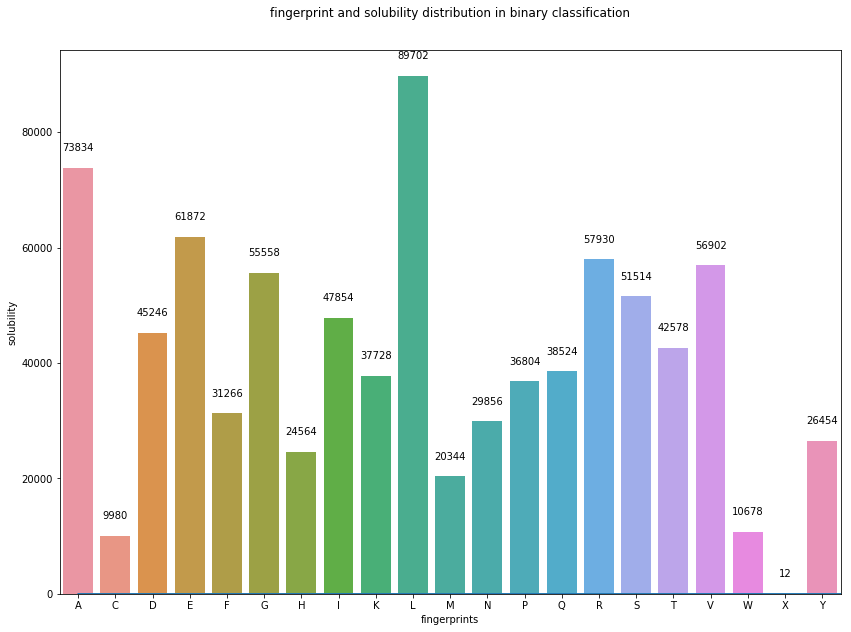

In [2]:
"""Load Biosensors"""
path='F:/'
cv=read_csv(path + 'processed_data.csv')
#InChi to SMILES
Train_chemical=load_chemicals(properties='Inchi',input_values=cv['chem'])
Train_seq=cv['seq']
Label=cv['label']
path=set_path("C:/Users/DR/Desktop/P2/Latent-master/pic/Combined_Model/biosensor/")
# Generate vocab
d_to_index=vis_seq_elements(Train_seq,path+'Frequencies Hist of Amino Acids Thermostability.svg')
"""Tokenize data"""
# Tokenlize chem
Train_chemical=flatten_chem(Train_chemical)
# Tokenlize seq_thermostability
Train_seq=tensor_pad(Train_seq,d_to_index)
# Hardmax thermostability
Label=hardmax(Label)
%load_ext ipython_bell

In [27]:
Seq_NN=create_network(layer_type=("LSTM",[Train_seq.shape[1],32,32,0]),outputlayer_type='',optimizer='Adam',Init='he_init',vocab=d_to_index,drop_out=0.5)
Chem_NN=create_network(layer_type=("DFF",[Train_chemical.shape[1],32,0]),outputlayer_type='',optimizer='Adam',Init='he_init')
combine_model = combine_models(Seq_NN,Train_seq.shape[1],Chem_NN,Train_chemical.shape[1])

In [30]:
%%bell -n say
#30
combine_model.compile(loss='binary_crossentropy',optimizer= 'Adam',metrics=['accuracy'])
c_m=combine_model.fit([Train_seq]+[Train_chemical],Label,batch_size=128, epochs=15,validation_split=0.3)

Train on 1786 samples, validate on 766 samples
Epoch 1/15
1786/1786 [==============================] - 24s 13ms/step - loss: 0.1558 - acc: 0.9429 - val_loss: 1.2130 - val_acc: 0.7389
Epoch 2/15
1786/1786 [==============================] - 24s 13ms/step - loss: 0.1436 - acc: 0.9502 - val_loss: 1.1655 - val_acc: 0.7402
Epoch 3/15
1786/1786 [==============================] - 24s 14ms/step - loss: 0.1214 - acc: 0.9574 - val_loss: 1.2131 - val_acc: 0.7520
Epoch 4/15
1786/1786 [==============================] - 25s 14ms/step - loss: 0.1099 - acc: 0.9602 - val_loss: 1.2842 - val_acc: 0.7324
Epoch 5/15
1786/1786 [==============================] - 25s 14ms/step - loss: 0.1128 - acc: 0.9591 - val_loss: 1.2719 - val_acc: 0.7454
Epoch 6/15
1786/1786 [==============================] - 26s 14ms/step - loss: 0.1120 - acc: 0.9608 - val_loss: 1.2789 - val_acc: 0.7441
Epoch 7/15
1786/1786 [==============================] - 25s 14ms/step - loss: 0.1131 - acc: 0.9580 - val_loss: 1.3337 - val_acc: 0.7402
E

## Transfer Learning

The frequency is: Counter({'L': 53531, 'A': 50534, 'G': 43643, 'V': 43613, 'E': 43415, 'I': 35336, 'K': 34816, 'R': 32726, 'D': 31297, 'S': 29990, 'T': 27349, 'P': 25605, 'F': 21545, 'N': 21151, 'Y': 18448, 'Q': 16743, 'M': 12832, 'H': 10729, 'W': 6661, 'C': 4756, 'X': 2, '@': 2, 'U': 1})
Amino acids type is: 23
They are: dict_keys(['M', 'F', 'A', 'T', 'N', 'V', 'S', 'I', 'L', 'K', 'E', 'Y', 'R', 'G', 'P', 'D', 'Q', 'H', 'W', 'C', 'X', 'U', '@'])
The original vector shape:
(1144, 1024, 4)
The flattened vector shape:
 (1144, 4096)
There are 587 soluble chemicals (positive samples) and 557 insoluble chemicals (negative samples).


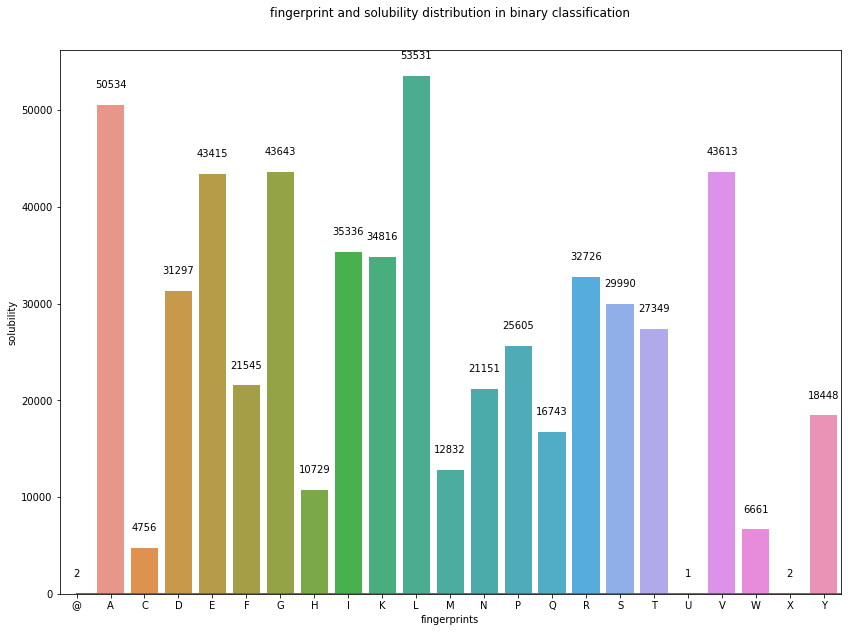

There are 915 soluble chemicals (positive samples) and 793 insoluble chemicals (negative samples).


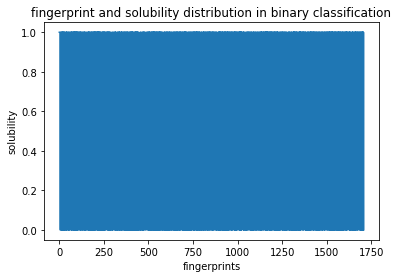

In [5]:
"""Set working directory"""
# If directory dosn't exixst, then create directory.   
path="C:/Users/DR/Desktop/P2/Latent-master/pic/Tranfer_Learning"
if not os.path.exists(path):
    os.mkdir(path)
"""Load Data"""
# Load seqs_thermoatability
non_thermophilic_proteins = readfasta("C:/Users/DR/Desktop/P2/Latent-master/data/thermostability/non-thermophilic_proteins.txt")
thermophilic_proteins = readfasta("C:/Users/DR/Desktop/P2/Latent-master/data/thermostability/thermophilic_proteins.txt")
thermophilic_proteins['Thermostability']='1'
non_thermophilic_proteins['Thermostability']='0'
# Append the thermophilic to the non-thermophilic
sequence_data=pd.concat([thermophilic_proteins,non_thermophilic_proteins])
sequence_data=sequence_data.sample(frac=1)
# Init input and Y
X_seq=sequence_data['seq']
Y_seq=sequence_data['Thermostability']

# Load chems_solubility
chem_data = load_chemicals(properties="Solubility",path="C:/Users/DR/Desktop/P2/Latent-master/data/solubility/delaney.csv")
chem_data.rename(columns={ chem_data.columns[1]: "Solubility"}, inplace=True)
X_chem=chem_data['SMILES']
Y_chem=np.array(chem_data['Solubility'])

"""Tokenize data"""
# Generate vocab
d1_to_index=vis_seq_elements(X_seq,path+'Frequencies Hist of Amino Acids Thermostability.svg')

# Tokenlize chem
X_chem=flatten_chem(X_chem)
# Tokenlize seq_thermostability
X_seq=tensor_pad(X_seq,d1_to_index)
# Hardmax solubility
Y_chem_hardmax=hardmax(Y_chem)
# Hardmax thermostability
Y_seq_hardmax=hardmax(Y_seq)

In [46]:
Chem_NN=create_network(layer_type=("DFF",[X_chem.shape[1],32,1]),outputlayer_type='binary_classifier',optimizer='Adam',Init='he_init')

Optimizer Adam; binary_crossentropy.


In [47]:
Chem_NN.compile(loss='binary_crossentropy',optimizer= 'Adam',metrics=['accuracy'])
Chem_NN.fit([X_chem],Y_chem_hardmax,batch_size=128, epochs=20)

Epoch 1/20
1144/1144 [==============================] - 1s 648us/step - loss: 0.6462 - acc: 0.6495
Epoch 2/20
1144/1144 [==============================] - 0s 70us/step - loss: 0.5274 - acc: 0.7753
Epoch 3/20
1144/1144 [==============================] - 0s 72us/step - loss: 0.4526 - acc: 0.8112
Epoch 4/20
1144/1144 [==============================] - 0s 70us/step - loss: 0.4007 - acc: 0.8514
Epoch 5/20
1144/1144 [==============================] - 0s 69us/step - loss: 0.3620 - acc: 0.8794
Epoch 6/20
1144/1144 [==============================] - 0s 71us/step - loss: 0.3296 - acc: 0.8977
Epoch 7/20
1144/1144 [==============================] - 0s 68us/step - loss: 0.3051 - acc: 0.9073
Epoch 8/20
1144/1144 [==============================] - 0s 69us/step - loss: 0.2834 - acc: 0.9091
Epoch 9/20
1144/1144 [==============================] - 0s 69us/step - loss: 0.2636 - acc: 0.9152
Epoch 10/20
1144/1144 [==============================] - 0s 70us/step - loss: 0.2453 - acc: 0.9213
Epoch 11/20
1144/1

In [50]:
Seq_NN=create_network(layer_type=("LSTM",[Train_seq.shape[1],32,32,0]),outputlayer_type='',optimizer='Adam',Init='he_init',vocab=d_to_index,drop_out=0.5)
combine_model = combine_models(Seq_NN,Train_seq.shape[1],Chem_NN_new,Train_chemical.shape[1])
Chem_NN_new=Model(inputs=Chem_NN.input,outputs=Chem_NN.get_layer('dense_22').output)

In [52]:
combine_model.compile(loss='binary_crossentropy',optimizer= 'Adam',metrics=['accuracy'])
c_k=combine_model.fit([Train_seq]+[Train_chemical],Label,batch_size=128, epochs=30,validation_split=0.3)

Train on 1786 samples, validate on 766 samples
Epoch 1/30
1786/1786 [==============================] - 24s 13ms/step - loss: 0.6966 - acc: 0.5224 - val_loss: 0.6949 - val_acc: 0.4922
Epoch 2/30
1786/1786 [==============================] - 22s 13ms/step - loss: 0.6754 - acc: 0.5795 - val_loss: 0.6747 - val_acc: 0.5587
Epoch 3/30
1786/1786 [==============================] - 23s 13ms/step - loss: 0.6318 - acc: 0.6428 - val_loss: 0.6574 - val_acc: 0.5640
Epoch 4/30
1786/1786 [==============================] - 23s 13ms/step - loss: 0.5617 - acc: 0.7301 - val_loss: 0.6424 - val_acc: 0.6436
Epoch 5/30
1786/1786 [==============================] - 23s 13ms/step - loss: 0.4899 - acc: 0.7676 - val_loss: 0.6721 - val_acc: 0.6645
Epoch 6/30
1786/1786 [==============================] - 23s 13ms/step - loss: 0.4184 - acc: 0.8180 - val_loss: 0.7004 - val_acc: 0.6645
Epoch 7/30
1786/1786 [==============================] - 23s 13ms/step - loss: 0.3568 - acc: 0.8561 - val_loss: 0.7144 - val_acc: 0.7245
E

In [58]:
training_vis(c_k,"binary_classifier",path+"/with tranfer learning.svg")

## Debug

In [40]:
"""Model Architecture"""
from keras.layers import Lambda
from keras.layers import normalization
Adam = optimizers.Adam(lr=0.015, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)

Seq_input=Train_seq.shape[1]
Chem_input=Train_chemical.shape[1]

Seq_input = Input(shape=(Seq_input,))
Chem_input = Input(shape=(Chem_input,))

embedding=Embedding(output_dim=32, input_dim=len(d_to_index), input_length=Train_seq.shape[1],embeddings_initializer='uniform')(Seq_input)
# lstm1=LSTM(32, return_sequences=True, activation='relu')(embedding)
# d1=Dropout(0.3)(lstm1)
lstm2=LSTM(32, return_sequences=True, activation='relu', go_backwards=True,kernel_initializer='he_normal',bias_initializer='zeros')(embedding)
d2=Dropout(0.5)(lstm2)
# lb=Lambda(lambda x: x * 0)(d2)
ft=Flatten()(d2)

chem1 = Dense(32, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros')(Chem_input)
# chem2 = Dense(32, activation='relu',kernel_initializer='he_normal',bias_initializer='zeros')(chem1)

merged_NN_b4 = layers.concatenate([ft, chem1])
NN1=Dense(128, activation='relu')(merged_NN_b4)
NN2=Dense(128, activation='relu')(NN1)
NN=Dense(128, activation='relu')(NN2)
merged_NN =  layers.Dense(units=1,activation='sigmoid')(NN)
combined_model = Model([Seq_input, Chem_input], merged_NN)
Adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-8)
combined_model.compile(loss='binary_crossentropy',optimizer= 'Adam',metrics=['accuracy'])

In [41]:
%%bell -n say
c_m=combined_model.fit([Train_seq]+[Train_chemical],Label,batch_size=128, epochs=30,validation_split=0.3)

Train on 1786 samples, validate on 766 samples
Epoch 1/30
1786/1786 [==============================] - 25s 14ms/step - loss: 0.6986 - acc: 0.5112 - val_loss: 0.6948 - val_acc: 0.4687
Epoch 2/30
1786/1786 [==============================] - 25s 14ms/step - loss: 0.6934 - acc: 0.5073 - val_loss: 0.7100 - val_acc: 0.4713
Epoch 3/30
1786/1786 [==============================] - 25s 14ms/step - loss: 0.6951 - acc: 0.4950 - val_loss: 0.6941 - val_acc: 0.4125
Epoch 4/30
1786/1786 [==============================] - 25s 14ms/step - loss: 0.6931 - acc: 0.5022 - val_loss: 0.6959 - val_acc: 0.4687
Epoch 5/30
1786/1786 [==============================] - 26s 14ms/step - loss: 0.6925 - acc: 0.5118 - val_loss: 0.6979 - val_acc: 0.4700
Epoch 6/30
1786/1786 [==============================] - 25s 14ms/step - loss: 0.6925 - acc: 0.5196 - val_loss: 0.6948 - val_acc: 0.4543
Epoch 7/30
1786/1786 [==============================] - 26s 15ms/step - loss: 0.6917 - acc: 0.5140 - val_loss: 0.7004 - val_acc: 0.4883
E

In [45]:
training_vis(c_m,"binary_classifier",path+"/without tranfer learning.svg")

## TF

In [ ]:
cv=read_csv( path + 'biosensor_seqs_annotated.csv')
"""Load Data"""
# cv.drop(['Unnamed: 0','Name','Organism'], axis=1,inplace=True)
cv = cv[pd.notnull(cv['InChI'])]
cv = cv[pd.notnull(cv['Seq'])]
cv=cv[cv.TF.isin(['YES'])]
cv=cv.sample(frac=1)
# Ori Data
X_chem_biosensor=cv['InChI']
X_seq_biosensor=cv['Seq']
Y_biosensor=pd.Series([1]*len(cv))
k1=pd.DataFrame({'chem':list(X_chem_biosensor),'seq':list(X_seq_biosensor),'label':list(Y_biosensor)})
# Contrast Data
X_chem_biosensor_new=X_chem_biosensor.shift(periods=2, freq=None, axis=0)
X_chem_biosensor_new[1073]=X_chem_biosensor[637]
X_chem_biosensor_new[862]=X_chem_biosensor[1150]
X_seq_biosensor_new=X_seq_biosensor
Y_biosensor_new=pd.Series([0]*len(cv))
k2=pd.DataFrame({'chem':list(X_chem_biosensor_new),'seq':list(X_seq_biosensor_new),'label':list(Y_biosensor_new)})
k1=k1.append(k2)
k1=k1.sample(frac=1)
k1.to_csv('F:/processed_data_TF.csv',index=True,sep=',')
cv=k1
#InChi to SMILES
Train_chemical=load_chemicals(properties='Inchi',input_values=cv['chem'])
Train_seq=cv['seq']
Label=cv['label']
path=set_path("C:/Users/DR/Desktop/P2/Latent-master/pic/Combined_Model/biosensor_TF/")
# Generate vocab
d_to_index=vis_seq_elements(Train_seq,path+'Frequencies Hist of Amino Acids Thermostability.svg')
"""Tokenize data"""
# Tokenlize chem
Train_chemical=flatten_chem(Train_chemical)
# Tokenlize seq_thermostability
Train_seq=tensor_pad(Train_seq,d_to_index)
# Hardmax thermostability
Label=hardmax(Label)
%load_ext ipython_bell

In [28]:
len(k1)/2

773.0

In [33]:
%%bell -n say
Seq_NN=create_network(layer_type=("LSTM",[Train_seq.shape[1],32,32,0]),outputlayer_type='',optimizer='Adam',Init='he_init',vocab=d_to_index,drop_out=0.5)
Chem_NN=create_network(layer_type=("DFF",[Train_chemical.shape[1],32,0]),outputlayer_type='',optimizer='Adam',Init='he_init')
combine_model = combine_models(Seq_NN,Train_seq.shape[1],Chem_NN,Train_chemical.shape[1])
combine_model.compile(loss='binary_crossentropy',optimizer= 'Adam',metrics=['accuracy'])
c_k=combine_model.fit([Train_seq]+[Train_chemical],Label,batch_size=128, epochs=60,validation_split=0.3)

Train on 1082 samples, validate on 464 samples
Epoch 1/60
1082/1082 [==============================] - 11s 10ms/step - loss: 0.6992 - acc: 0.4797 - val_loss: 0.6956 - val_acc: 0.5022
Epoch 2/60
1082/1082 [==============================] - 9s 8ms/step - loss: 0.6937 - acc: 0.5065 - val_loss: 0.6963 - val_acc: 0.4978
Epoch 3/60
1082/1082 [==============================] - 9s 8ms/step - loss: 0.6942 - acc: 0.5018 - val_loss: 0.6954 - val_acc: 0.5000
Epoch 4/60
1082/1082 [==============================] - 9s 8ms/step - loss: 0.6921 - acc: 0.5333 - val_loss: 0.6967 - val_acc: 0.4440
Epoch 5/60
1082/1082 [==============================] - 9s 8ms/step - loss: 0.6910 - acc: 0.5231 - val_loss: 0.6973 - val_acc: 0.4203
Epoch 6/60
1082/1082 [==============================] - 9s 8ms/step - loss: 0.6876 - acc: 0.5665 - val_loss: 0.7021 - val_acc: 0.4720
Epoch 7/60
1082/1082 [==============================] - 9s 8ms/step - loss: 0.6796 - acc: 0.5860 - val_loss: 0.7074 - val_acc: 0.5323
Epoch 8/60
10

## Varified

In [35]:
path='F:/'
cv=read_csv( path + 'biosensor_seqs_annotated.csv')
"""Load Data"""
# cv.drop(['Unnamed: 0','Name','Organism'], axis=1,inplace=True)
cv = cv[pd.notnull(cv['InChI'])]
cv = cv[pd.notnull(cv['Seq'])]
cv=cv[cv.Verified.isin(['OK'])]
cv=cv.sample(frac=1)
# Ori Data
X_chem_biosensor=cv['InChI']
X_seq_biosensor=cv['Seq']
Y_biosensor=pd.Series([1]*len(cv))
k1=pd.DataFrame({'chem':list(X_chem_biosensor),'seq':list(X_seq_biosensor),'label':list(Y_biosensor)})
# Contrast Data
X_chem_biosensor_new=X_chem_biosensor.shift(periods=2, freq=None, axis=0)


In [37]:
X_chem_biosensor_new

223                                                   NaN
55                                                    NaN
806                                           InChI=1S/Cu
448     InChI=1S/C5H10O5/c6-2-1-10-5(9)4(8)3(2)7/h2-9H...
350     InChI=1S/C5H13O14P3/c6-3-2(1-16-20(8,9)10)17-5...
111     InChI=1S/C5H8O4/c1-3(6)5(2,9)4(7)8/h9H,1-2H3,(...
727            InChI=1S/C2H5NO2/c3-1-2(4)5/h1,3H2,(H,4,5)
665     InChI=1S/C7H6O2/c8-7(9)6-4-2-1-3-5-6/h1-5H,(H,...
405     InChI=1S/C29H42N7O17P3S/c1-29(2,24(40)27(41)32...
289                                           InChI=1S/Cu
598                                      InChI=1S/NO/c1-2
281                     InChI=1S/HNO2/c2-1-3/h(H,2,3)/p-1
525               InChI=1S/C6H6O/c7-6-4-2-1-3-5-6/h1-5,7H
219         InChI=1S/C7H8O/c1-6-2-4-7(8)5-3-6/h2-5,8H,1H3
486     InChI=1S/C10H15N5O10P2/c11-8-5-9(13-2-12-8)15(...
44      InChI=1S/C12H22O11/c13-1-4-6(16)8(18)9(19)11(2...
514     InChI=1S/C6H4Cl2O2/c7-3-1-5(9)4(8)2-6(3)10/h1-...
112     InChI=

The frequency is: Counter({'L': 64154, 'A': 50754, 'E': 41184, 'R': 40352, 'V': 38118, 'I': 33676, 'G': 33674, 'S': 33156, 'D': 28786, 'Q': 27556, 'T': 27396, 'K': 23612, 'P': 22690, 'F': 19854, 'N': 18970, 'H': 17122, 'Y': 16590, 'M': 13338, 'C': 6008, 'W': 5600})
Amino acids type is: 20
They are: dict_keys(['M', 'F', 'D', 'K', 'R', 'H', 'I', 'T', 'L', 'N', 'A', 'Y', 'Q', 'V', 'E', 'G', 'S', 'W', 'P', 'C'])
The original vector shape:
(1798, 1024, 4)
The flattened vector shape:
 (1798, 4096)
There are 898 soluble chemicals (positive samples) and 900 insoluble chemicals (negative samples).


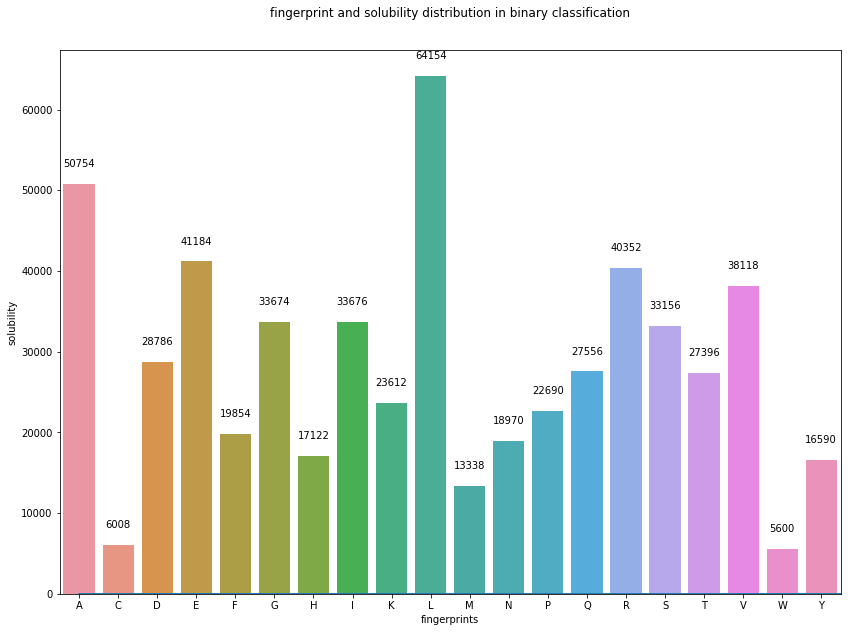

The ipython_bell extension is already loaded. To reload it, use:
  %reload_ext ipython_bell


In [38]:
X_chem_biosensor_new[223]=X_chem_biosensor[29]
X_chem_biosensor_new[55]=X_chem_biosensor[308]
X_seq_biosensor_new=X_seq_biosensor
Y_biosensor_new=pd.Series([0]*len(cv))
k2=pd.DataFrame({'chem':list(X_chem_biosensor_new),'seq':list(X_seq_biosensor_new),'label':list(Y_biosensor_new)})
k1=k1.append(k2)
k1=k1.sample(frac=1)
k1.to_csv('F:/processed_data_TF.csv',index=True,sep=',')
cv=k1
#InChi to SMILES
Train_chemical=load_chemicals(properties='Inchi',input_values=cv['chem'])
Train_seq=cv['seq']
Label=cv['label']
path=set_path("C:/Users/DR/Desktop/P2/Latent-master/pic/Combined_Model/biosensor_TF/")
# Generate vocab
d_to_index=vis_seq_elements(Train_seq,path+'Frequencies Hist of Amino Acids Thermostability.svg')
"""Tokenize data"""
# Tokenlize chem
Train_chemical=flatten_chem(Train_chemical)
# Tokenlize seq_thermostability
Train_seq=tensor_pad(Train_seq,d_to_index)
# Hardmax thermostability
Label=hardmax(Label)
%load_ext ipython_bell

In [40]:
len(k1)/2

899.0

In [41]:
%%bell -n say
Seq_NN=create_network(layer_type=("LSTM",[Train_seq.shape[1],32,32,0]),outputlayer_type='',optimizer='Adam',Init='he_init',vocab=d_to_index,drop_out=0.5)
Chem_NN=create_network(layer_type=("DFF",[Train_chemical.shape[1],32,0]),outputlayer_type='',optimizer='Adam',Init='he_init')
combine_model = combine_models(Seq_NN,Train_seq.shape[1],Chem_NN,Train_chemical.shape[1])
combine_model.compile(loss='binary_crossentropy',optimizer= 'Adam',metrics=['accuracy'])
c_k=combine_model.fit([Train_seq]+[Train_chemical],Label,batch_size=128, epochs=60,validation_split=0.3)

Train on 1258 samples, validate on 540 samples
Epoch 1/60
1258/1258 [==============================] - 21s 16ms/step - loss: 0.7120 - acc: 0.4881 - val_loss: 0.7018 - val_acc: 0.4981
Epoch 2/60
1258/1258 [==============================] - 19s 15ms/step - loss: 0.6984 - acc: 0.4881 - val_loss: 0.6997 - val_acc: 0.4981
Epoch 3/60
1258/1258 [==============================] - 19s 15ms/step - loss: 0.6987 - acc: 0.4714 - val_loss: 0.6936 - val_acc: 0.5019
Epoch 4/60
1258/1258 [==============================] - 18s 14ms/step - loss: 0.6945 - acc: 0.5000 - val_loss: 0.6942 - val_acc: 0.4981
Epoch 5/60
1258/1258 [==============================] - 18s 14ms/step - loss: 0.6936 - acc: 0.4762 - val_loss: 0.6935 - val_acc: 0.5019
Epoch 6/60
1258/1258 [==============================] - 18s 15ms/step - loss: 0.6929 - acc: 0.5000 - val_loss: 0.6935 - val_acc: 0.5333
Epoch 7/60
1258/1258 [==============================] - 18s 14ms/step - loss: 0.6922 - acc: 0.5429 - val_loss: 0.6936 - val_acc: 0.5000
E

1258/1258 [==============================] - 19s 15ms/step - loss: 0.1026 - acc: 0.9610 - val_loss: 1.4614 - val_acc: 0.7444
